# Desafio Parte 3

## Tarefa 3: Processamento da Trusted

### Instruções da tarefa

**Processamento -  Camada Trusted**

A camada **Trusted** de um data lake corresponde àquela em que os dados encontram-se limpos e são confiáveis. É resultado da integração das diversas fontes de origem, que encontram-se na camada anterior, que chamamos de **Raw**.

Aqui faremos uso do Apache Spark no processo, integrando dados existentes na camada Raw Zone. O objetivo é gerar uma visão padronizada dos dados, persistida no S3,  compreendendo a Trusted Zone do data lake.  Nossos jobs Spark serão criados por meio do AWS Glue.

Todos os dados serão persistidos na **Trusted** no formato PARQUET, particionados por data de criação do *tweet*  ou data de coleta do TMDB (*dt=<ano\mês\dia> exemplo: dt=2018\03\31*). A exceção fica para os dados oriundos do processamento *batch (CSV)*, que não precisam ser particionados.

Iremos separar o processamento em dois jobs: o primeiro, para carga histórica, será responsável pelo processamento dos arquivos CSV  e o segundo, para carga de dados do Twitter/TMDB. Lembre-se que suas origens serão os dados existentes na RAW Zone.

**Importante:**

Desenvolva os **jobs** no Glue utilizando a opção **Spark script editor**.  Após, na aba **Job details**, atente para as seguintes opções:

- **Worker type**: Informe G 1x (opção de menor configuração).

- **Requested  number of workers**: Informe 2, que é a quantidade mínima.

- **Job timeout (minutes)**: Mantenha em 60 ou menos, se possível.

### Código

#### 1ª Versão:

In [ ]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.dynamicframe import DynamicFrame

## Define o bucket S3 de origem e o caminho do arquivo para os dados JSON
source_bucket = "data-lake-da-telma"
source_file_path = "Raw/TMDB/JSON/Superhero/2023/04/13/superhero.json"
collection_date = "2023/04/13"


## Cria GlueContext e SparkContext
sc = SparkContext()
glueContext = GlueContext(sc)

## Cria a DynamicFrame dos dados de origem no formato JSON
source_dyf = glueContext.create_dynamic_frame_from_options(
    "s3",
    {"paths": [f"s3://{source_bucket}/{source_file_path}"]},
    "json"
)

## Define o bucket S3 de destino e o caminho do arquivo para os dados do Parquet na zona Truested
destination_bucket = "data-lake-da-telma"
destination_file_path = f"Trusted/{collection_date}.parquet"

## Converte DynamicFrame em um DataFrame
source_df = source_dyf.toDF()

## Converte o DataFrame em um DynamicFrame no formato Parquet
destination_dyf = DynamicFrame.fromDF(
    source_df,
    glueContext,
    "parquet"
)

## Salva o DynamicFrame no formato Parquet no bucket S3 de destino com caminho do arquivo na zona trusted
glueContext.write_dynamic_frame.from_options(
    frame = destination_dyf,
    connection_type = "s3",
    connection_options = {"path": f"s3://{destination_bucket}/{destination_file_path}"},
    format = "parquet"
) 

#### 2ª Versão

In [ ]:
import sys
from awsglue.transforms import *
from pyspark.context import SparkContext
from awsglue.context import GlueContext

# Define o bucket S3 de origem e o caminho do arquivo para os dados JSON
source_bucket = "data-lake-da-telma"
source_file_path = "Raw/TMDB/JSON/Superhero/2023/04/27/superhero.json"
collection_date = "2023/04/27"

# Cria GlueContext e SparkContext
sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session

# Lê os dados em JSON usando o esquema
source_df = spark.read.json(f"s3://{source_bucket}/{source_file_path}")

# Define o bucket S3 de destino e o caminho do arquivo para os dados do Parquet na zona Truested
destination_bucket = "data-lake-da-telma"
destination_file_path = f"Trusted/{collection_date}"

source_df.write.format("parquet").save(f"s3://{destination_bucket}/{destination_file_path}/superhero")

# encerra a sessão Spark
spark.stop() 

### Prints

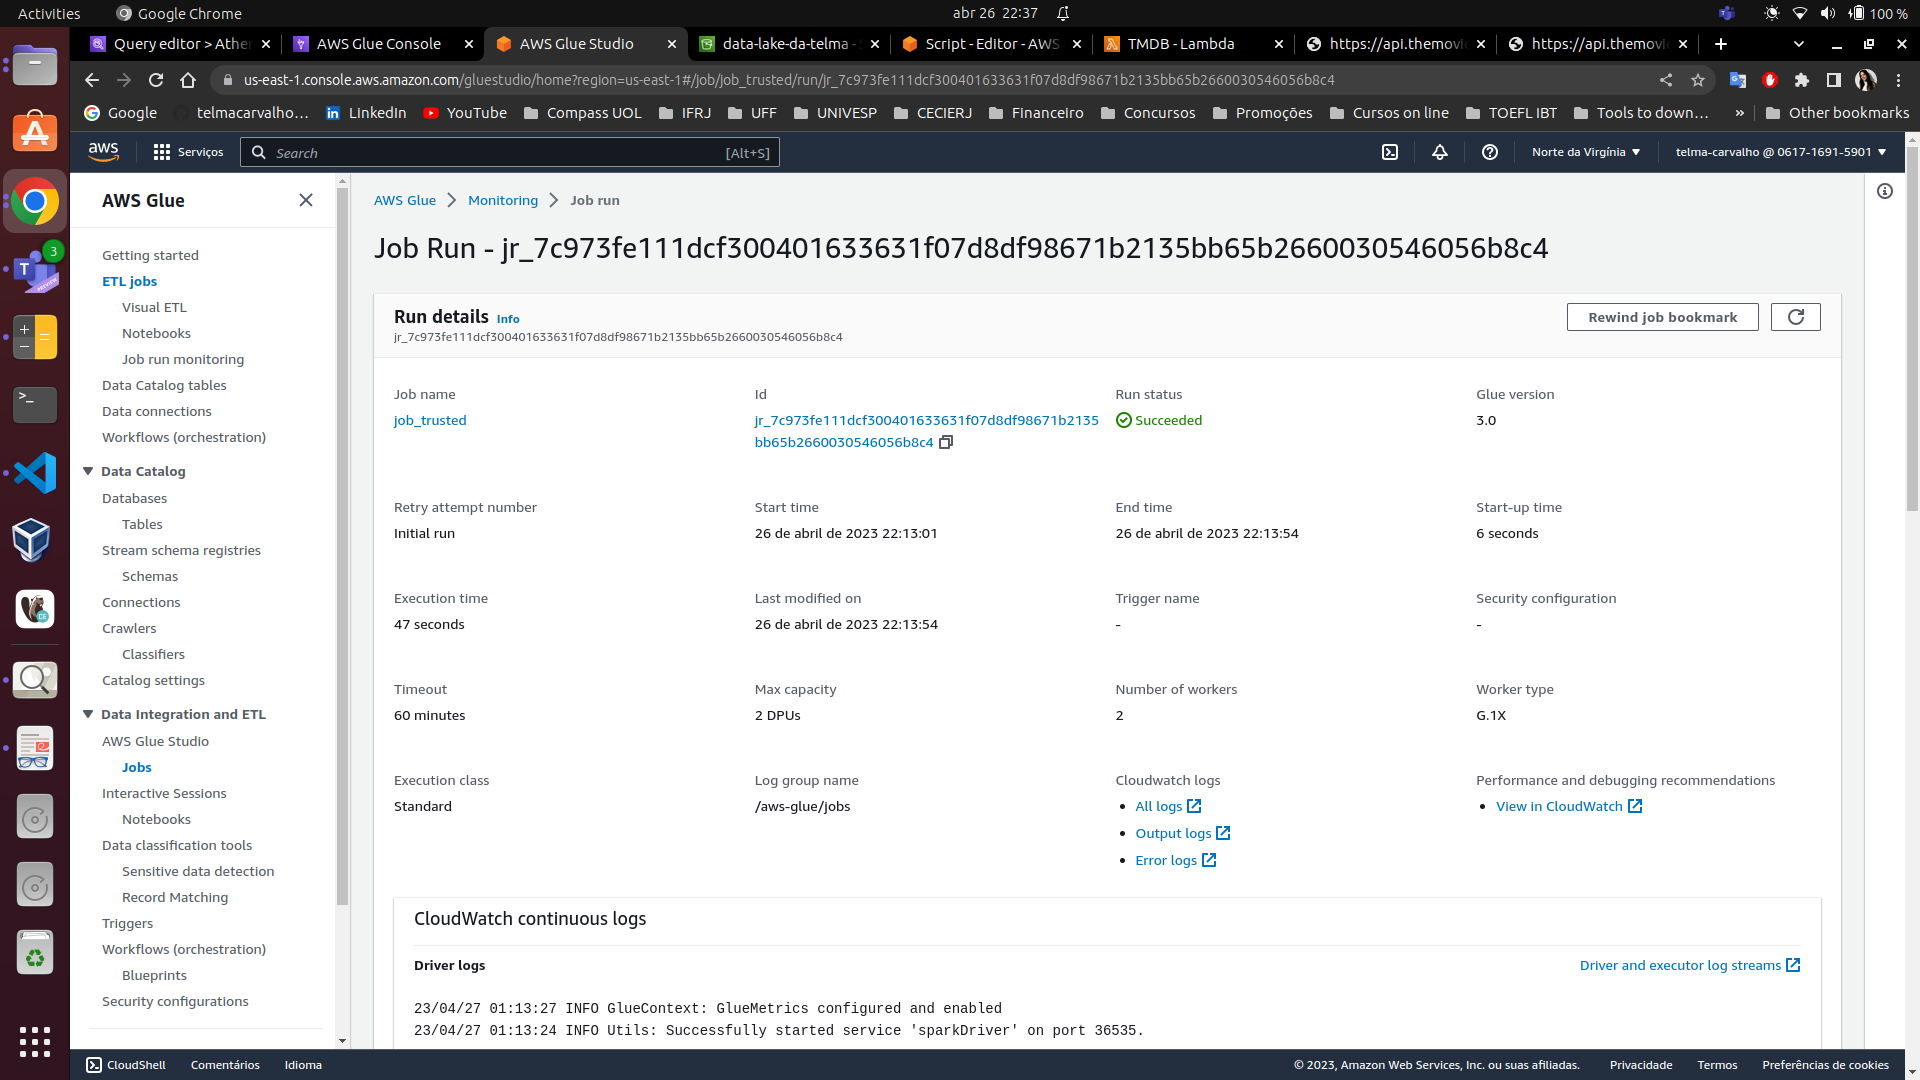

In [7]:
from IPython.display import Image
Image("Prints/job_run.png")

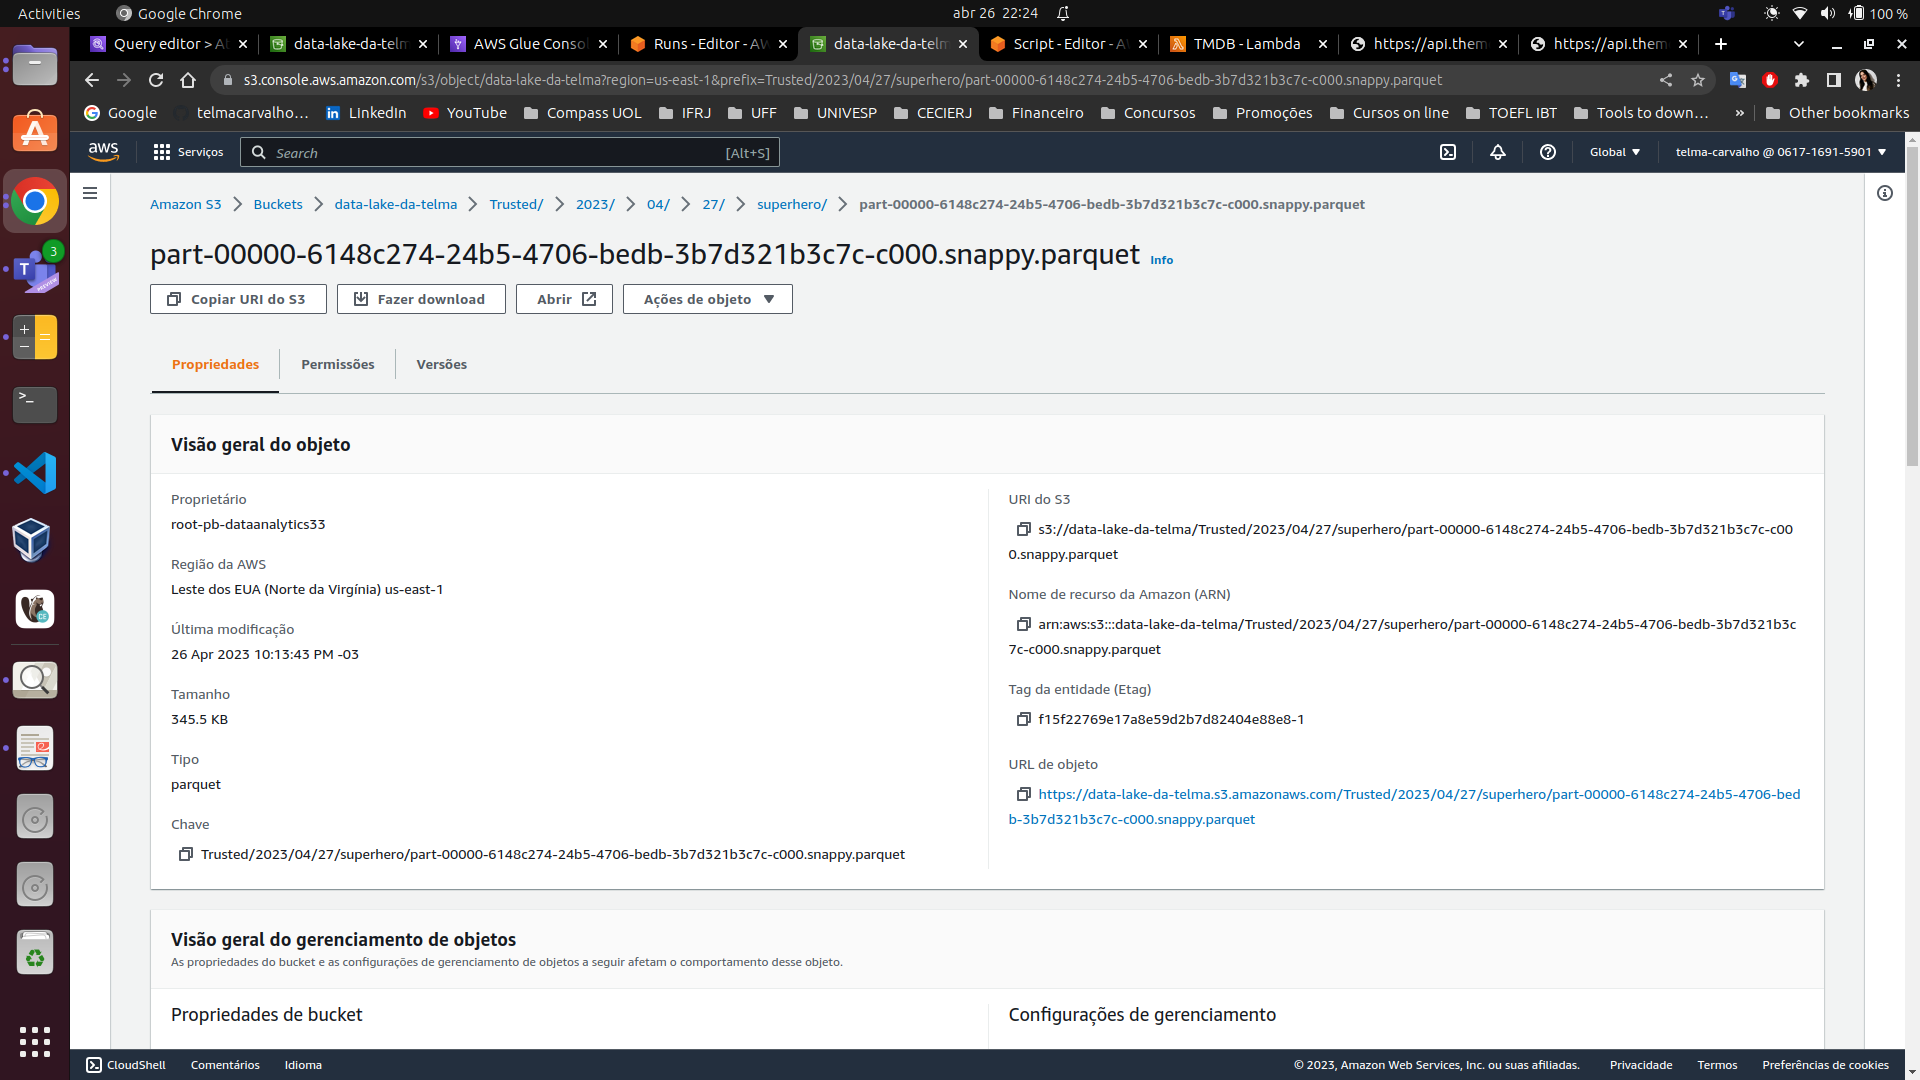

In [8]:
from IPython.display import Image
Image("Prints/data_trusted_zone.png")

## Tarefa 4: Modelagem de dados da Refined

### Instruções da tarefa

**Modelagem de dados - Camada Refined**

A camada Refined corresponde à camada de um data lake em que os dados estão prontos para análise e extração de insights. Sua origem corresponde aos dados da camada anterior, a Trusted.

Devemos pensar em estruturar os dados seguindo os princípios de modelagem multidimensional, a fim de permitir consultas sobre diferentes perspectivas.

Nesta etapa do desafio, devem ser criadas no AWS Glue Data Catalog  as tabelas e, se necessário, views,  de acordo com modelagem de dados solicitada, a fim de disponibilizar os dados para a ferramenta de visualização (QuickSight, a partir da próxima Sprint). Lembre-se que a origem será os dados oriundos da Trusted Zone.

**Perguntas dessa tarefa**

1. Apresentar a modelagem de dados da camada Refined. Você pode exportar seu modelo de dados na forma de imagem e registrar aqui. Lembre-se de deixá-lo disponível também no seu repositório do Github.

### Modelagem de dados da camada refined

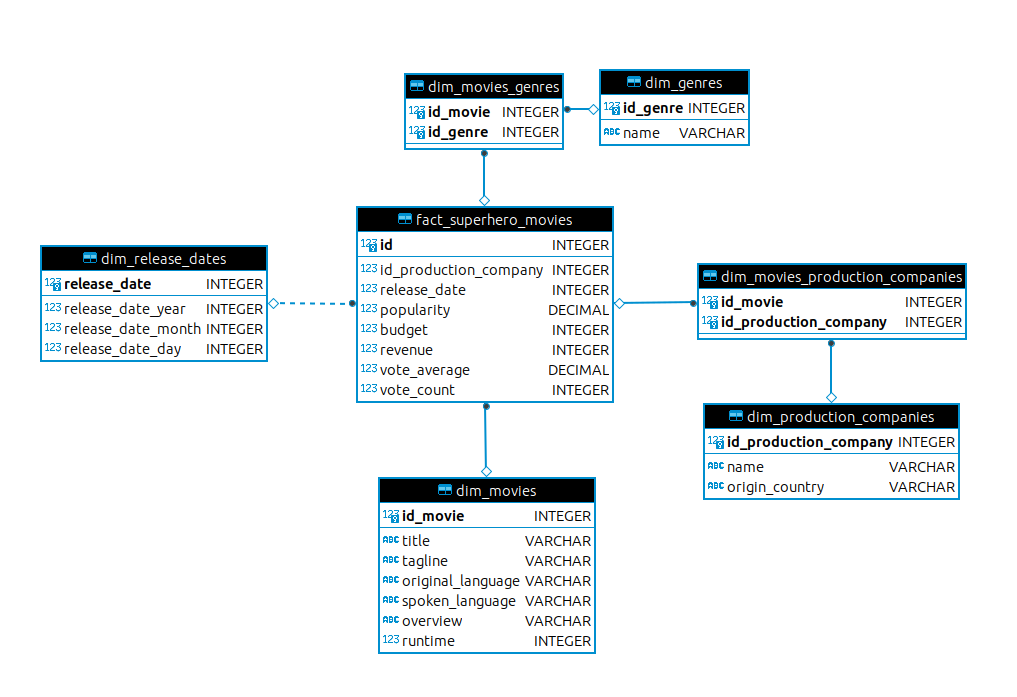

In [12]:
from IPython.display import Image
Image("Prints/Modelagem_dimensional_desafio.png")

## Tarefa 5: Processamento da Refined

### Instruções da tarefa

Na atividade anterior, você definiu seu modelo de dados da camada Trusted. Agora é tempo de processar os dados da camada Trusted, armazena-os na Refined, de acordo com seu modelo.

Aplicaremos novamente o Apache Spark no processo, utilizando jobs cuja origem sejam dados da camada Trusted Zone e e o destino, a camada Refined Zone.  Aqui, novamente, todos os dados serão persistidos no formato *PARQUET*, particionados, se necessário,  de acordo com as necessidades definidas para a camada de visualização.

**Importante**:

Desenvolva os **jobs** no *Glue* utilizando a opção **Spark script editor**. Após, na aba Job details, atente para as seguintes opções:

- **Worker type**: Informe G 1x (opção de menor configuração).

- **Requested number of workers**: Informe 2, que é a quantidade mínima.

- **Job timeout (minutes)**: Mantenha em 60 ou menos, se possível.

Após realizar a atividade, lembre-se de finalizar qualquer execução ativa de job para não incorrer em custos desnecessários.

**Perguntas dessa tarefa**

1. Desenvolva os jobs de processamento de acordo com as instruções. Aqui você pode apresentar prints do seu código. Lembre-se também de adicionar todo código produzido ao seu repositório no Github.

### Códigos